# Tone Notebook

tbh this file will be cleaned up/deleted

Using answer by Gus B from: https://stackoverflow.com/questions/49264194/import-py-file-in-another-directory-in-jupyter-notebook
Kinda whack but whatever for now. Run the next cell only ONCE (cd..), it changes the working directory to the parent so we can import stuff from the tonami, utils, etc. folder. If you mess up, restart the Jupyter kernel. Run the (cd..) cell again every time you restart.

In [1]:
%cd ..

/app


In [2]:
import warnings
import math
import os
from itertools import zip_longest

import matplotlib.pyplot as plt
import numpy as np
import plotnine as p9
import pandas as pd

from tonami import pitch_process as pp
from dev import parse_data
from data_viz import viz

warnings.filterwarnings("ignore", message="PySoundFile failed. Trying audioread instead.")

## Pitch Contour Analysis

In [3]:
# load pitch data from all speakers
pitch_data_parselmouth = pd.read_json('data/parsed/toneperfect_pitch_parselmouth.json')
pitch_data_librosa_50_500 = pd.read_json('data/parsed/toneperfect_pitch_librosa_50-500-fminmax.json')

SPEAKERS = ['FV1', 'FV2', 'FV3', 'MV1', 'MV2', 'MV3']
TONES = [1, 2, 3, 4]
# dynamically get speaker and tone combos for tone perfect dataset
spkr_tone_combos = [(x, y) for x in SPEAKERS for y in TONES]


In [41]:
# https://stackoverflow.com/questions/27826666/plotting-1000-lines-with-ggplot2
def plot_raw_pitch(data, spkr:str, tone:int, suffix:str, folder='data/images/', save=False, show=True):
    """Plot raw pitch contours for a single speaker and tone and save the
    resulting figure in folder.
    
    Args:
        data (pandas.DataFrame): pitch information and metadata dataset
        spkr (str): speaker id
        tone (int): tone number 1-4
        suffix (str): append to saved image name
        folder (str): location to save graph
        save (bool): flag to save 
        show (bool): flag to show plot or not
    """
    spkr_data = data.loc[(data['speaker'] == spkr) & (data['tone'] == tone), 'pitch_contour']
    padded = viz.pad_matrix(np.array(spkr_data))
    # mean_data = padded.mean()
    idx_names = [f'contour{i}' for i in range(padded.shape[0])]
    df = pd.DataFrame(padded, index=idx_names)
    df['contour'] = idx_names
    # sort of "unrolling" the matrix to plot as a line
    df_melt = pd.melt(df, id_vars='contour')
    pitch_plot = p9.ggplot(data=df_melt, mapping=p9.aes(x='variable', y='value', group='contour'))
    # TODO: plot mean
    title = f'Raw Pitch {spkr} Tone{tone} {suffix}'
    fig = pitch_plot + p9.theme_bw() + p9.geom_line(size=0.3, alpha=0.2) + p9.theme(figure_size=(14, 8)) + p9.ggtitle(title) \
        + p9.xlab('Sample') + p9.ylab('Frequency (Hz)')
    if save:
        filename = os.path.join(folder, f'{spkr}_t{tone}_pitch_{suffix}.png')
        fig.save(filename=filename)
    if show:
        fig.draw(show=True)

def plot_normalized_pitch(data, spkr:str, tone:int, suffix:str, folder='data/images/', save=False, show=True):
    """Plot raw pitch contours for a single speaker and tone and save the
    resulting figure in folder.
    
    Args:
        data (pandas.DataFrame): pitch information and metadata dataset
        spkr (str): speaker id
        tone (int): tone number 1-4
        suffix (str): append to saved image name
        folder (str): location to save graph
        save (bool): flag to save 
        show (bool): flag to show plot or not
    """
    all_spkr_data = data.loc[data['speaker'] == spkr, 'pitch_contour']
    spkr_arr = viz.pad_matrix(np.array(all_spkr_data))
    spkr_max = np.nanmax(spkr_arr)
    spkr_min = np.nanmin(spkr_arr)
    
    spkr_data = data.loc[(data['speaker'] == spkr) & (data['tone'] == tone), 'pitch_contour']
    padded = viz.pad_matrix(np.array(spkr_data))
    # avg_df = padded_df.apply(lambda x: pp.moving_average(x), axis=1)  
    idx_names = [f'contour{i}' for i in range(padded.shape[0])]
    df = pd.DataFrame(padded, index=idx_names)
    normalized_df = df.applymap(lambda x: pp.normalize_pitch(x, spkr_max, spkr_min))
    normalized_df['contour'] = idx_names
    # sort of "unrolling" the matrix to plot as a line
    df_melt = pd.melt(normalized_df, id_vars='contour')
    pitch_plot = p9.ggplot(data=df_melt, mapping=p9.aes(x='variable', y='value', group='contour'))
    # TODO: plot mean
    title = f' Normalized {spkr} Tone{tone} {suffix}'
    fig = pitch_plot + p9.theme_bw() + p9.geom_line(size=0.3, alpha=0.2) + p9.theme(figure_size=(14, 8)) + p9.ggtitle(title) + p9.ylim(0,5) \
        + p9.xlab('Sample') + p9.ylab('Chao 5-Point Scale')
    if save:
        filename = os.path.join(folder, f'{spkr}_t{tone}_pitch_normalized_{suffix}.png')
        fig.save(filename=filename)
    if show:
        fig.draw(show=True)

        
# for item in spkr_tone_combos:
#     plot_raw_pitch(pitch_data_librosa_50_500, item[0], item[1], 'librosa_50-500-fminmax')

def get_vad(pitch_contours):
    truncated = []
    for row in pitch_contours:
        df = pd.DataFrame(row)
        first_idx = df.first_valid_index()
        last_idx = df.last_valid_index()
        cut = df.loc[first_idx:last_idx]
        truncated.append(cut.values.flatten())
    return truncated   

def plot_nans(data, spkr:str, tone:int, suffix:str, folder='data/images/', save=False, show=True):
    """Plot a bar graph of NaNs for a single speaker and tone and save the
    resulting figure in folder.
    
    # TODO: run this with voice activity detection
    
    Args:
        data (pandas.DataFrame): pitch information and metadata dataset
        spkr (str): speaker id
        tone (int): tone number 1-4
        suffix (str): append to saved image name
        folder (str): location to save graph
        save (bool): flag to save local copy of graph
        show (bool): flag to show plot or not
    """
    spkr_data = data.loc[(data['speaker'] == spkr) & (data['tone'] == tone), 'pitch_contour']
    trunc_data = get_vad(spkr_data)
    padded = viz.pad_matrix(np.array(trunc_data), 'owo')
    df = pd.DataFrame(padded)
    nan_count = df[df == 'nan'].count() / spkr_data.shape[0]
    og_nans = pd.DataFrame({'variable': np.arange(len(nan_count)), 'NaN Count': nan_count})
    # print(og_nans)
    title = f'{spkr} Tone{tone} NaNs {suffix}'
    nan_plot = p9.ggplot(data=og_nans, mapping=p9.aes(x='variable', y='NaN Count'))
    fig = nan_plot + p9.geom_bar(stat = "identity") + p9.theme(figure_size=(14, 8)) + p9.ggtitle(title) \
        + p9.xlab('Sample') + p9.ylab('NaN Count (%)') + p9.scale_y_continuous(labels=lambda l: ["%d%%" % (v * 100) for v in l]) + p9.ylim(0,1)
    if save:
        filename = os.path.join(folder, f'{spkr}_t{tone}_nans_{suffix}.png')
        fig.save(filename=filename)
    if show:
        fig.draw(show=True)




/opt/conda/lib/python3.9/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 14 rows containing missing values.


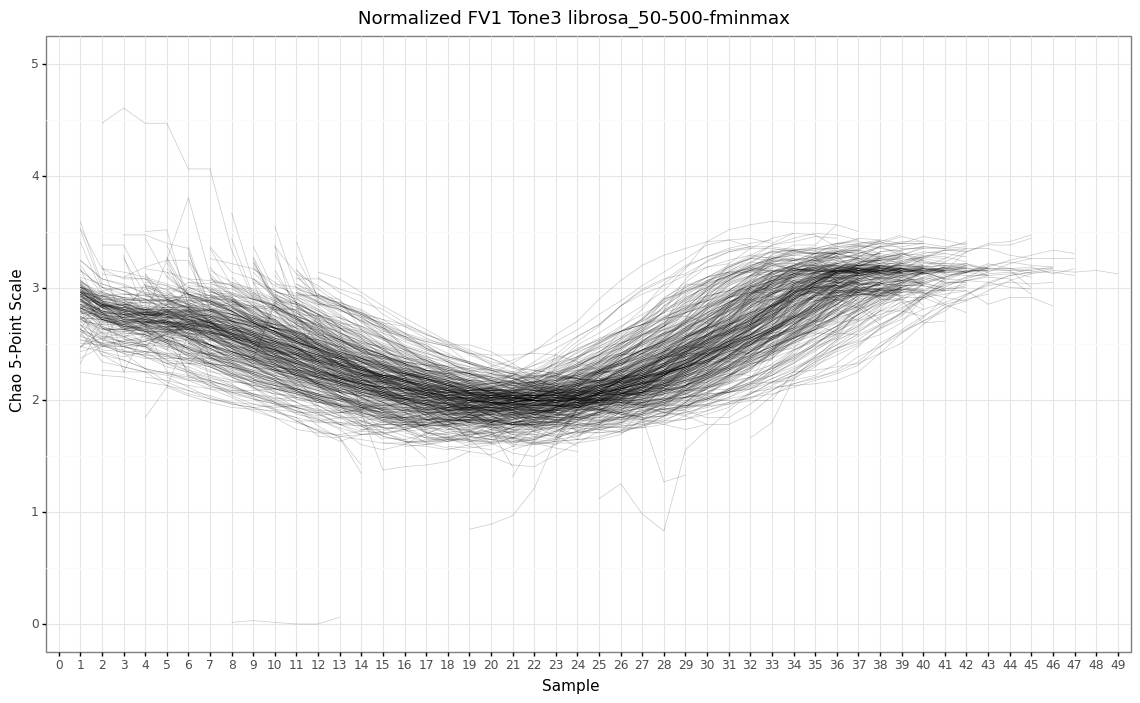

/tmp/ipykernel_149/4125362351.py:103: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/opt/conda/lib/python3.9/site-packages/plotnine/scales/scales.py:29: PlotnineWarning: Scale for 'y' is already present.
Adding another scale for 'y',
which will replace the existing scale.



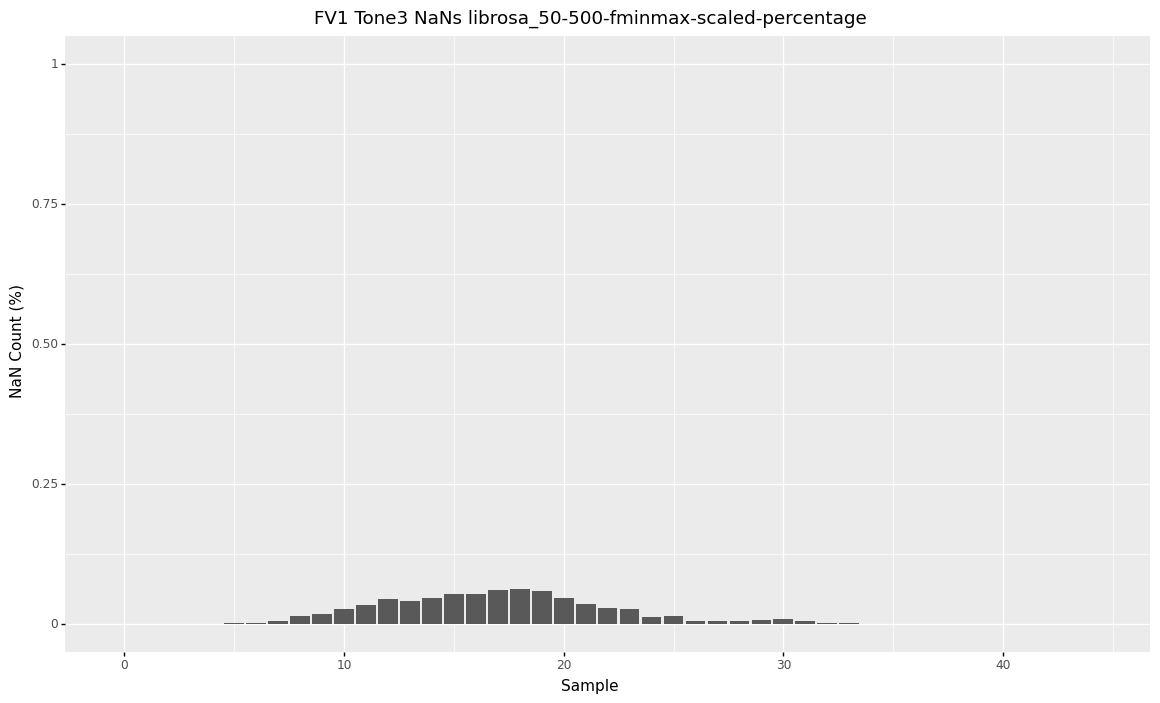

/opt/conda/lib/python3.9/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 22 rows containing missing values.


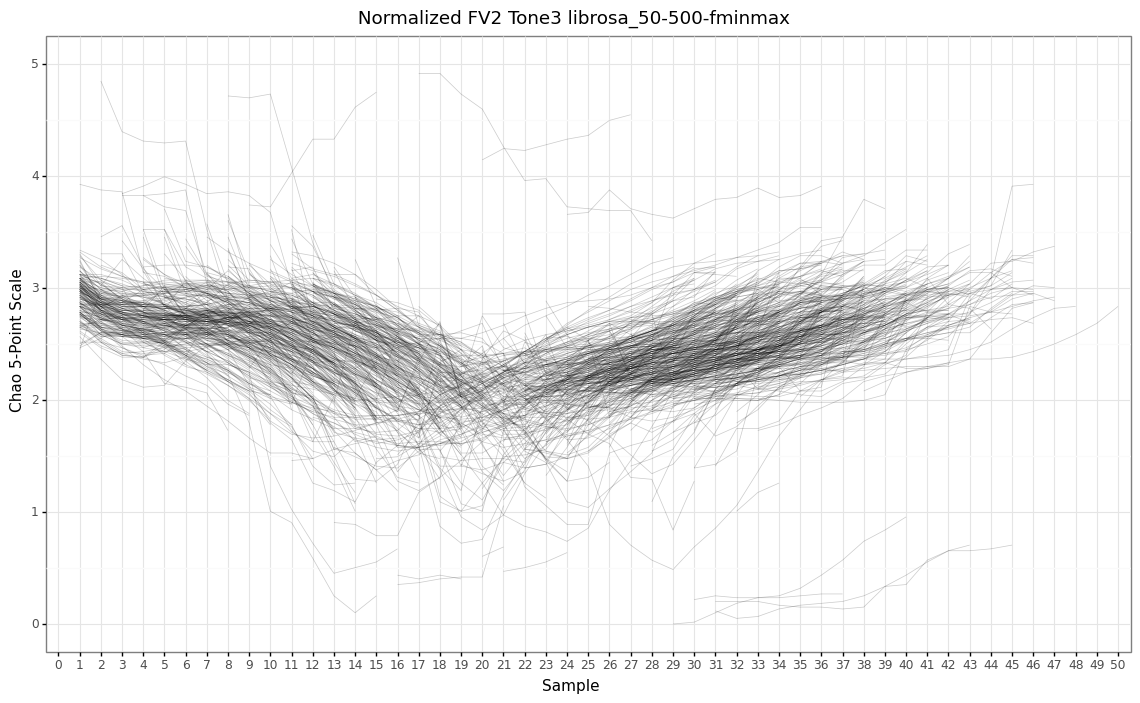

/tmp/ipykernel_149/4125362351.py:103: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/opt/conda/lib/python3.9/site-packages/plotnine/scales/scales.py:29: PlotnineWarning: Scale for 'y' is already present.
Adding another scale for 'y',
which will replace the existing scale.



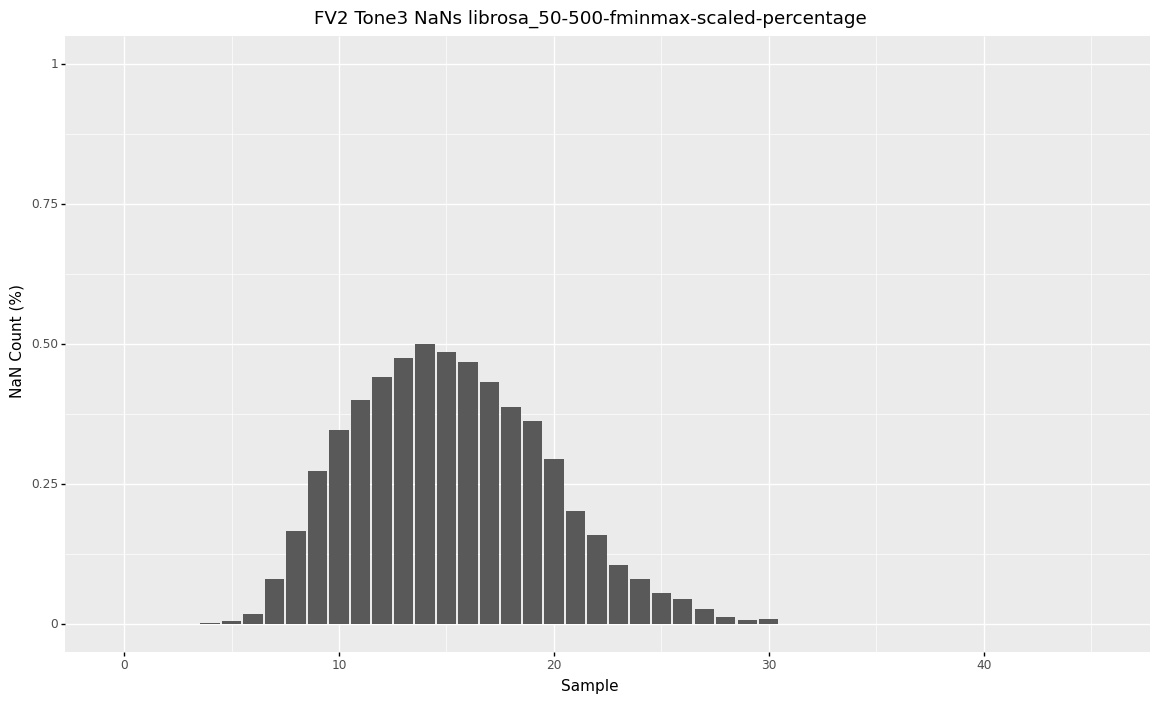

/opt/conda/lib/python3.9/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 18 rows containing missing values.


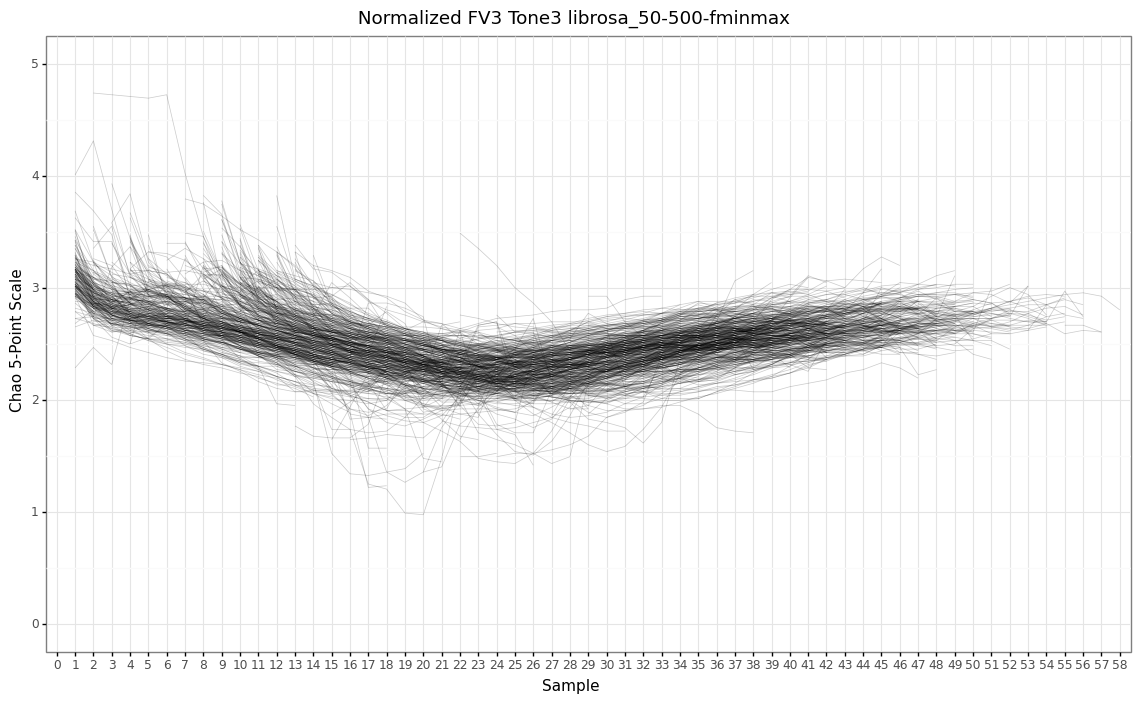

/tmp/ipykernel_149/4125362351.py:103: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/opt/conda/lib/python3.9/site-packages/plotnine/scales/scales.py:29: PlotnineWarning: Scale for 'y' is already present.
Adding another scale for 'y',
which will replace the existing scale.



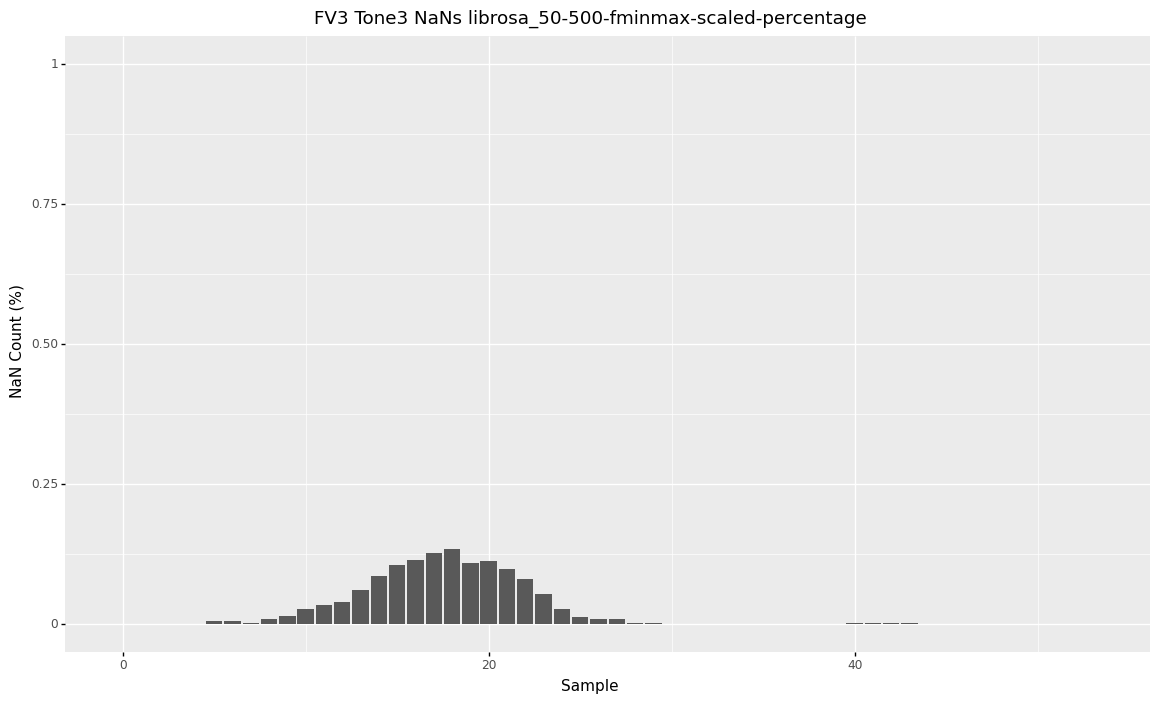

/opt/conda/lib/python3.9/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 14 rows containing missing values.


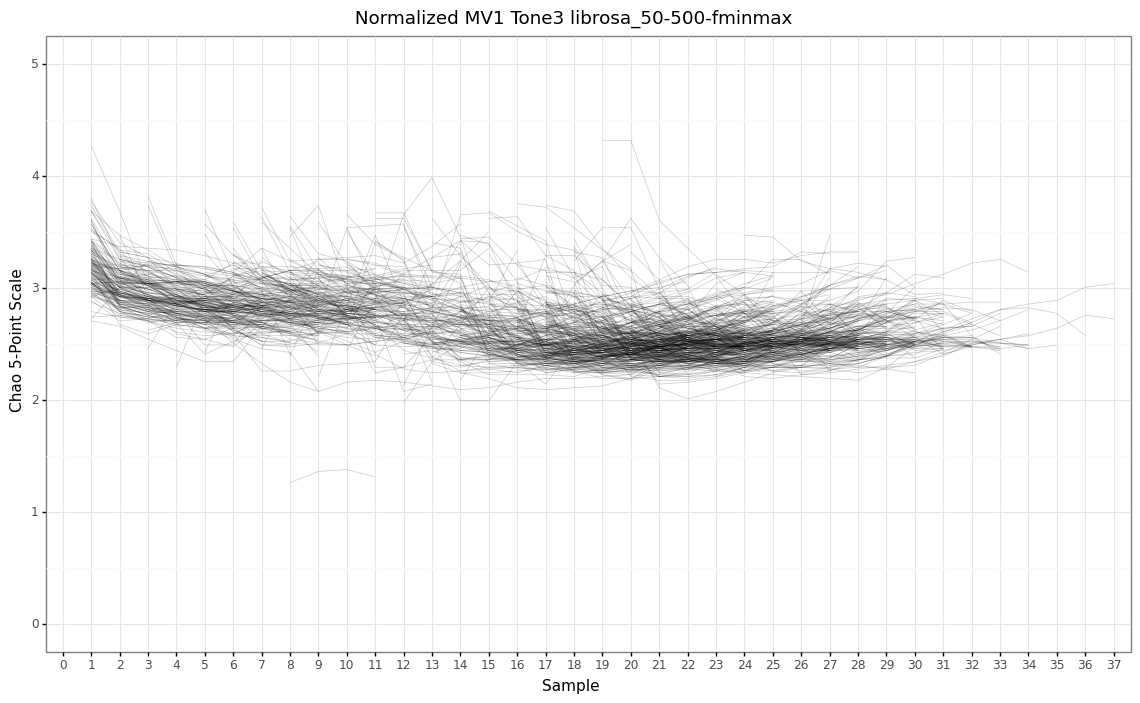

/tmp/ipykernel_149/4125362351.py:103: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/opt/conda/lib/python3.9/site-packages/plotnine/scales/scales.py:29: PlotnineWarning: Scale for 'y' is already present.
Adding another scale for 'y',
which will replace the existing scale.



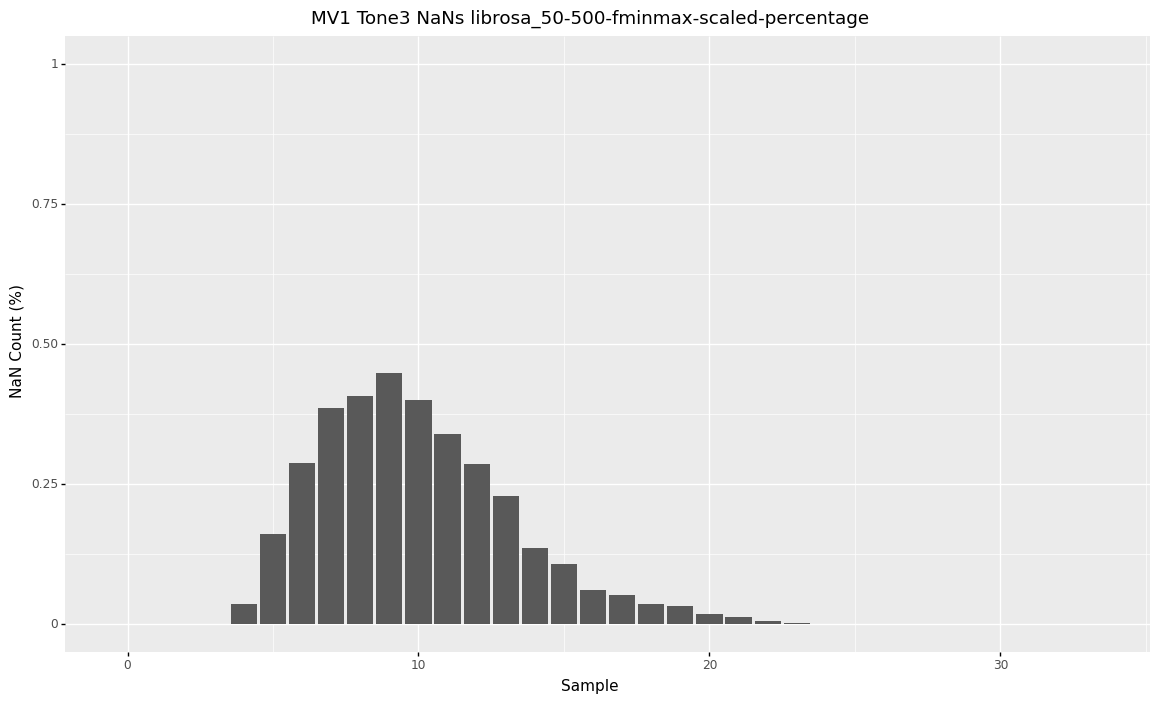

/opt/conda/lib/python3.9/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 23 rows containing missing values.


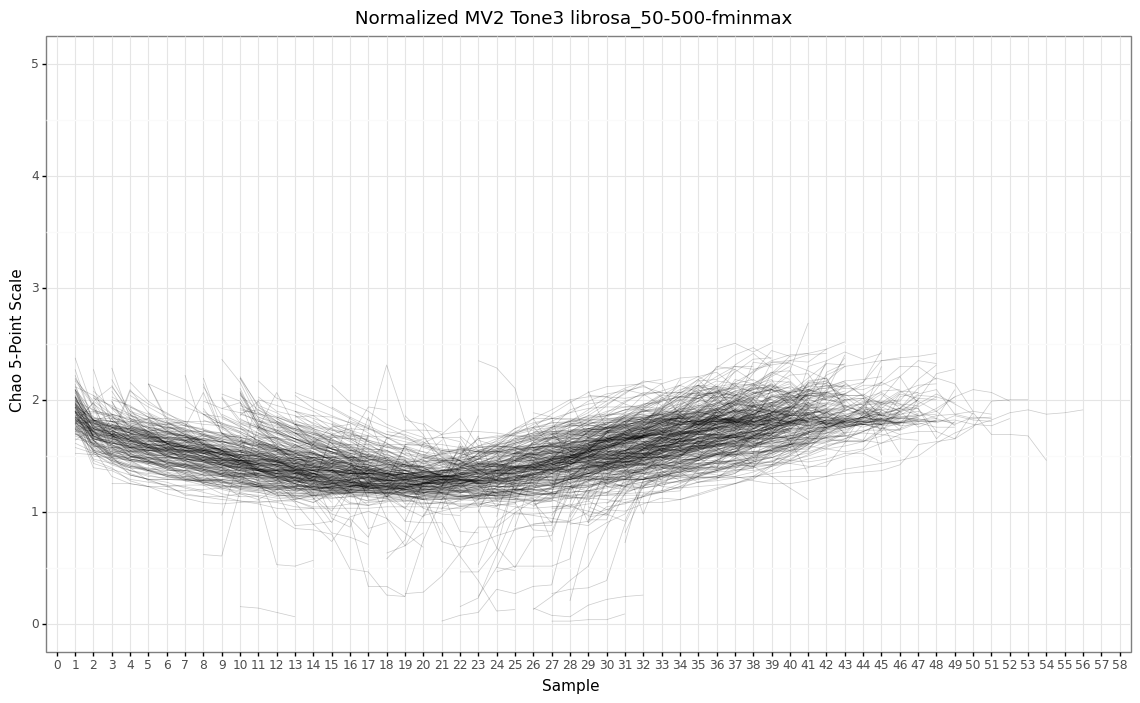

/tmp/ipykernel_149/4125362351.py:103: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/opt/conda/lib/python3.9/site-packages/plotnine/scales/scales.py:29: PlotnineWarning: Scale for 'y' is already present.
Adding another scale for 'y',
which will replace the existing scale.



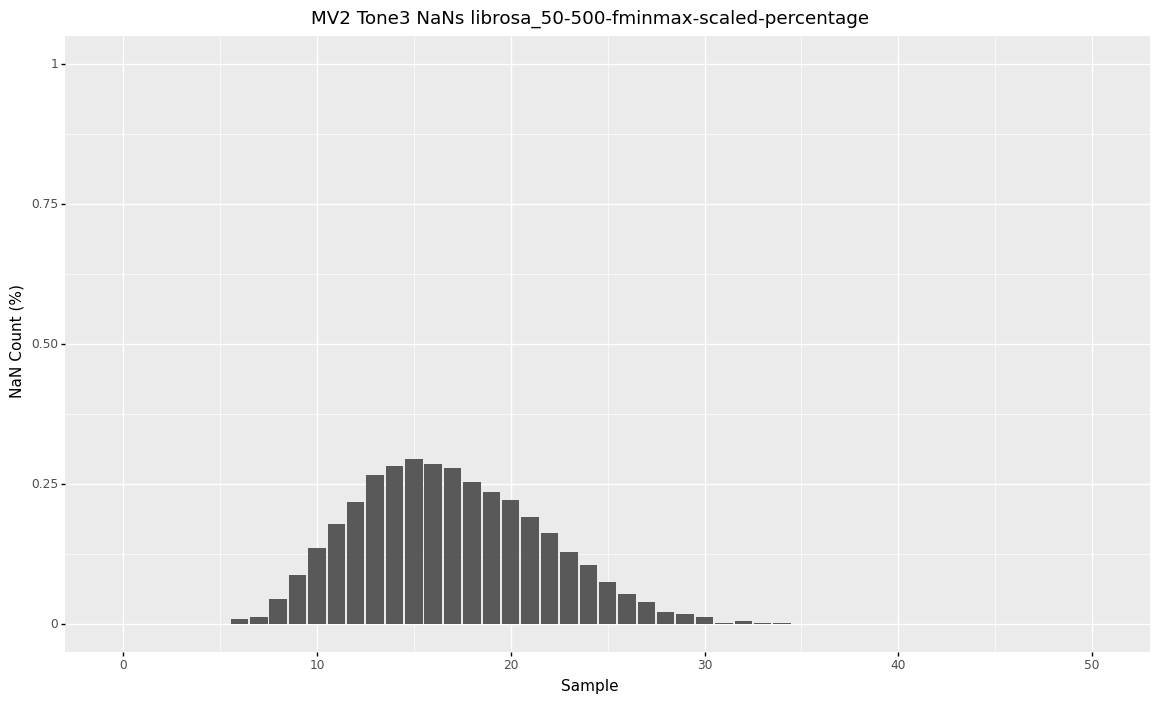

/opt/conda/lib/python3.9/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 12 rows containing missing values.


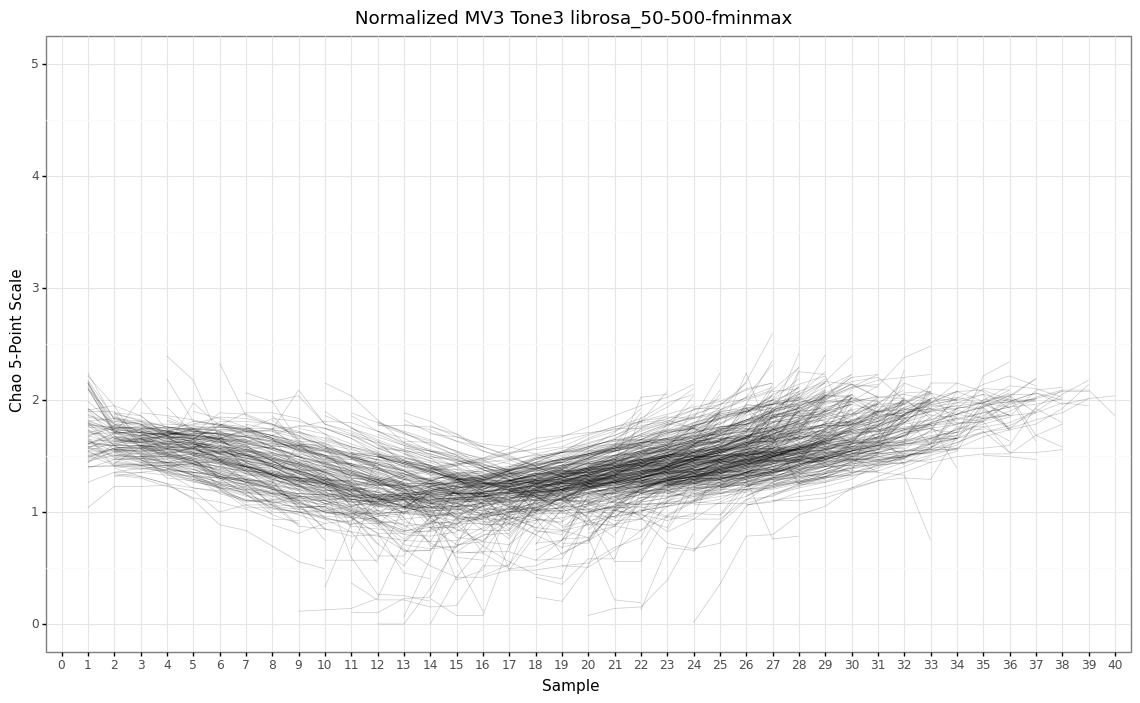

/tmp/ipykernel_149/4125362351.py:103: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/opt/conda/lib/python3.9/site-packages/plotnine/scales/scales.py:29: PlotnineWarning: Scale for 'y' is already present.
Adding another scale for 'y',
which will replace the existing scale.



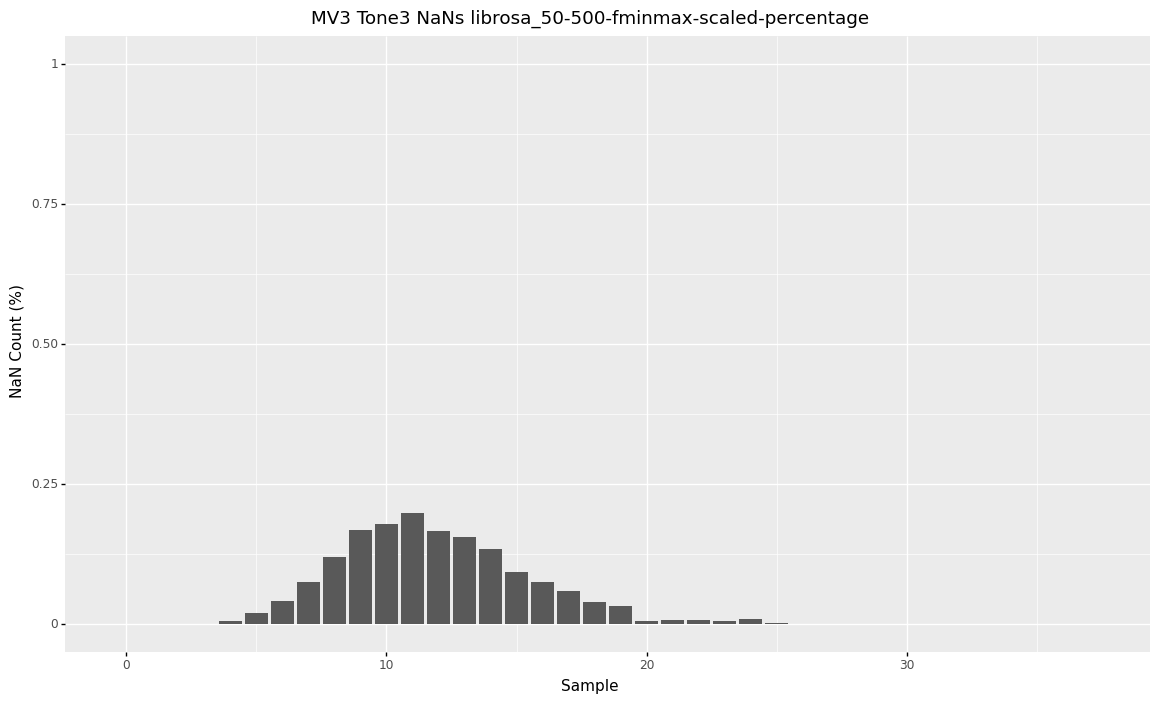

In [43]:
# batch graphing
TONES = [1, 2, 3, 4]
tone3_combos = [(x, y) for x in SPEAKERS for y in [3]]

for item in tone3_combos:
    plot_normalized_pitch(pitch_data_librosa_50_500, item[0], item[1], 'librosa_50-500-fminmax', show=True, save=False)
    plot_nans(pitch_data_librosa_50_500, item[0], item[1], 'librosa_50-500-fminmax-scaled-percentage', show=True, save=False)


# for item in spkr_tone_combos:
    # normalized pitch contours on 5 point scale
    # plot_normalized_pitch(pitch_data_librosa_50_500, item[0], item[1], 'librosa_50-500-fminmax', show=False, save=True)
    # plot_normalized_pitch(pitch_data_parselmouth, item[0], item[1], 'parselmouth', show=False, save=True)

    # raw pitch contours
    # plot_raw_pitch(pitch_data_librosa_50_500, item[0], item[1], 'librosa_50-500-fminmax', show=False, save=True)
    # plot_raw_pitch(pitch_data_parselmouth, item[0], item[1], 'parselmouth', show=False, save=True)
    # nans
    # plot_nans(pitch_data_librosa_50_500, item[0], item[1], 'librosa_50-500-fminmax-scaled-percentage', show=False, save=True)
    # plot_nans(pitch_data_parselmouth, item[0], item[1], 'parselmouth-scaled-percentage', show=False, save=True)
    # break
# plot_nans(pitch_data_librosa_50_500, 'FV2', 3, 'librosa_50-500-fminmax', show=True, save=False)

/opt/conda/lib/python3.9/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 21 rows containing missing values.


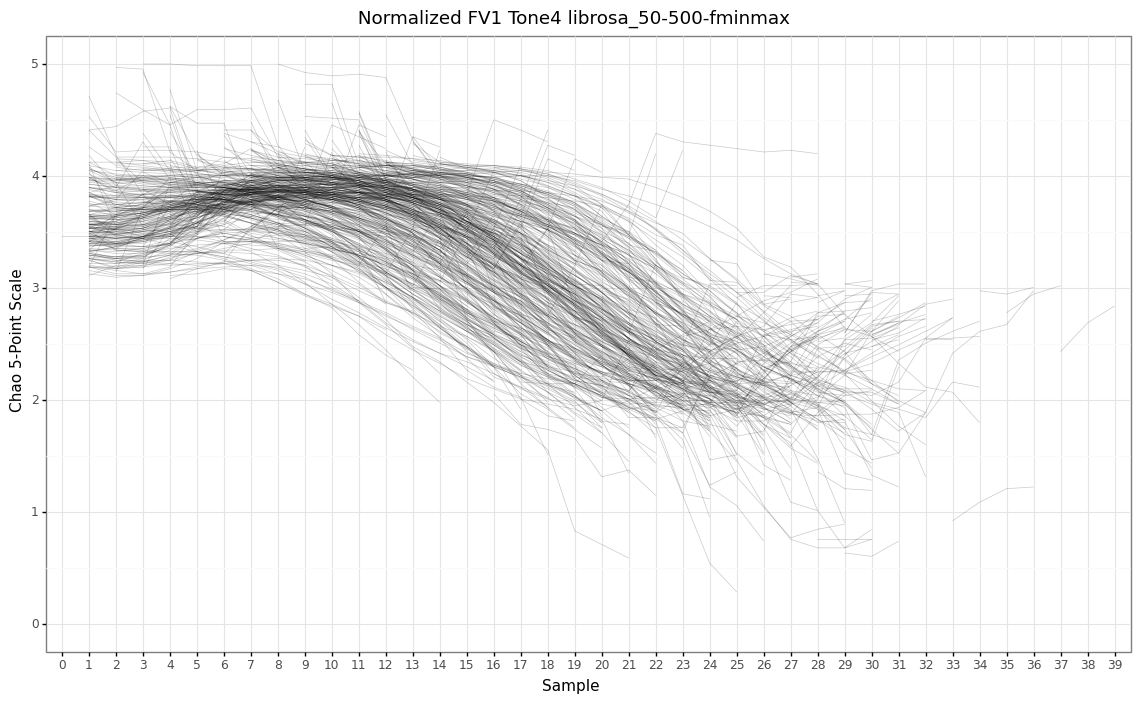

/tmp/ipykernel_149/4125362351.py:103: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/opt/conda/lib/python3.9/site-packages/plotnine/scales/scales.py:29: PlotnineWarning: Scale for 'y' is already present.
Adding another scale for 'y',
which will replace the existing scale.



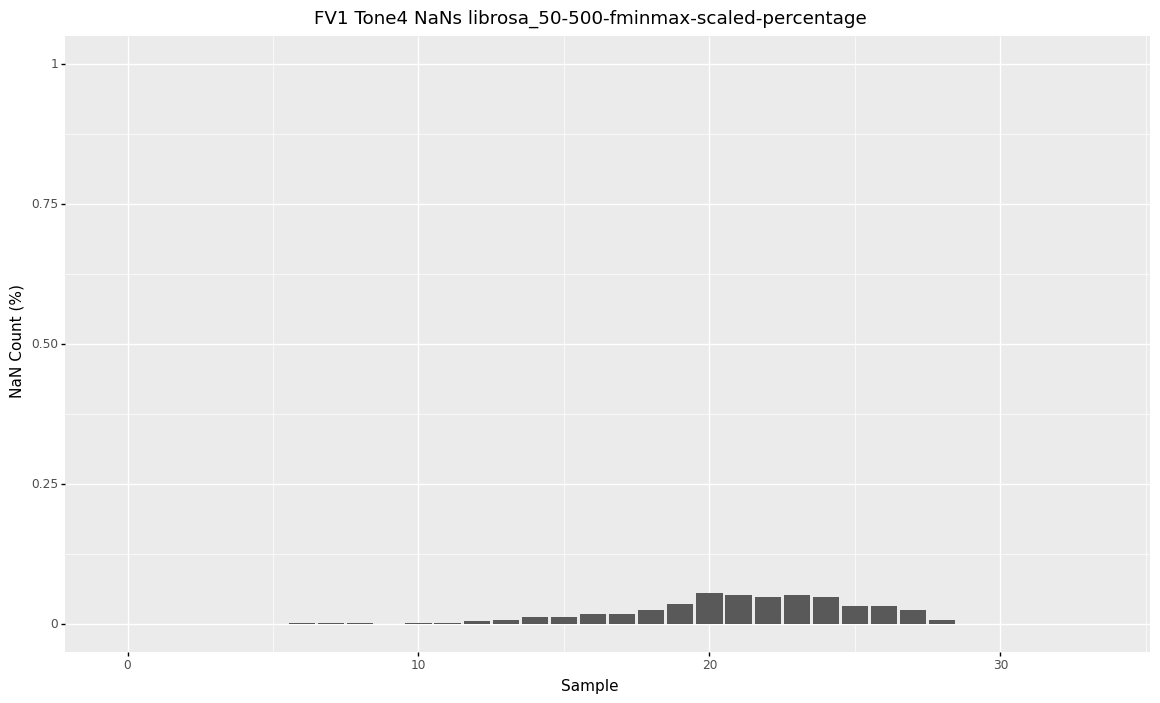

/opt/conda/lib/python3.9/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 24 rows containing missing values.


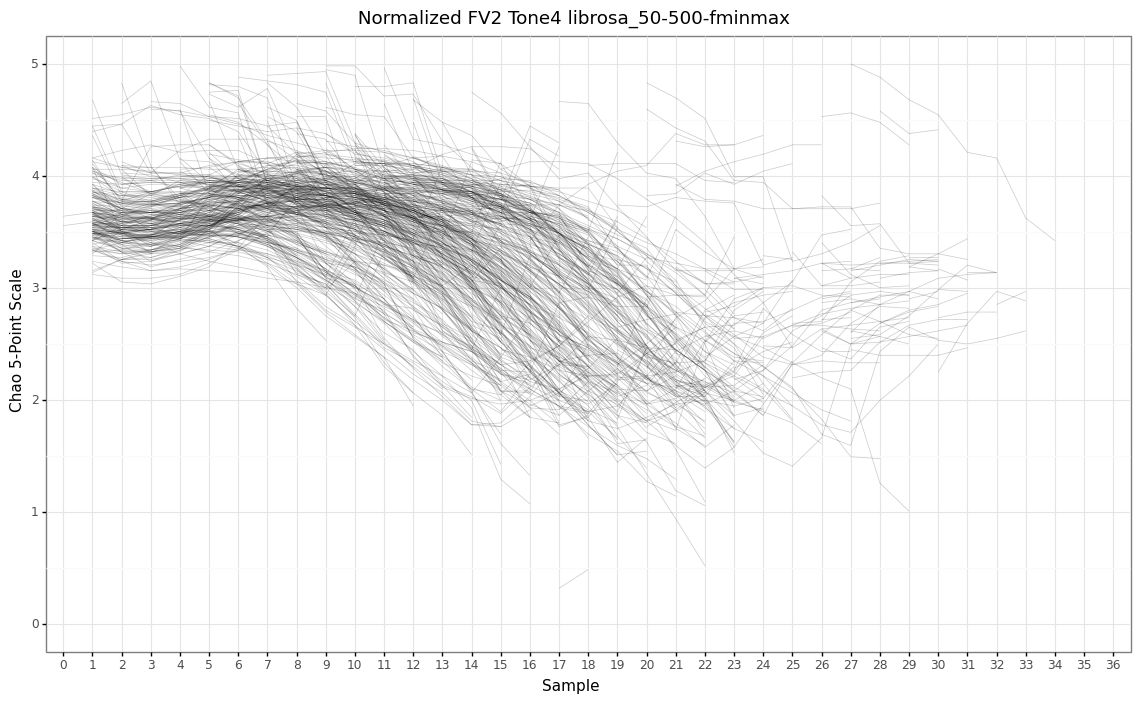

/tmp/ipykernel_149/4125362351.py:103: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/opt/conda/lib/python3.9/site-packages/plotnine/scales/scales.py:29: PlotnineWarning: Scale for 'y' is already present.
Adding another scale for 'y',
which will replace the existing scale.



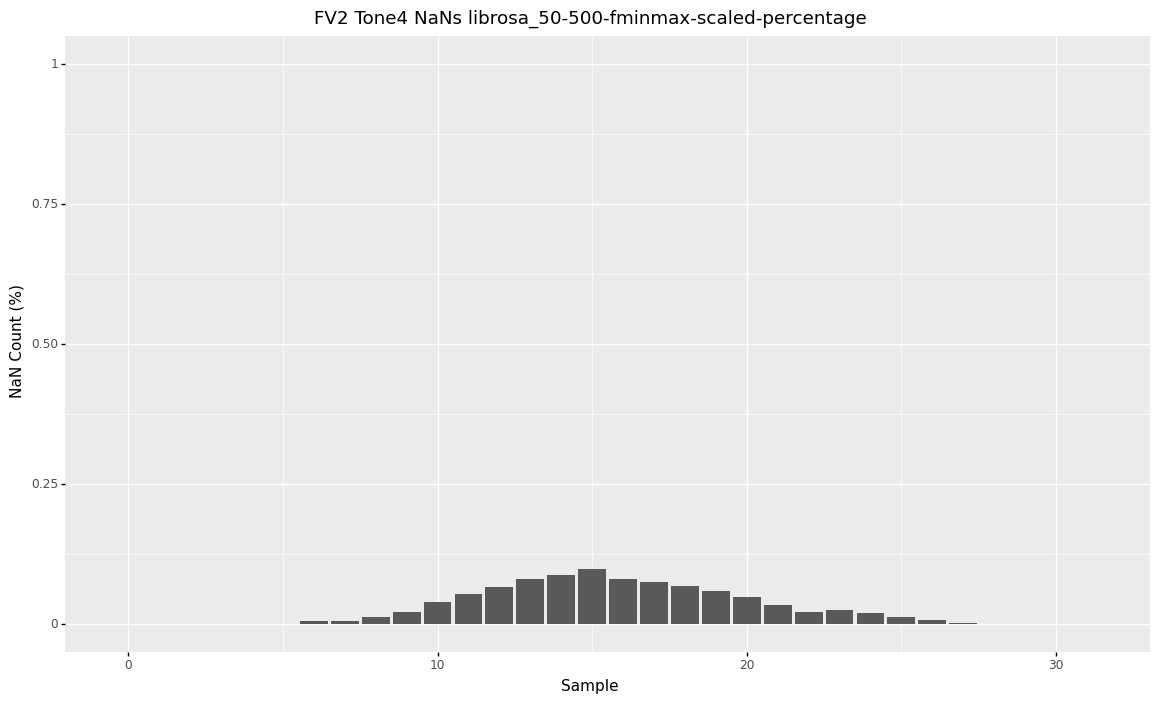

/opt/conda/lib/python3.9/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 24 rows containing missing values.


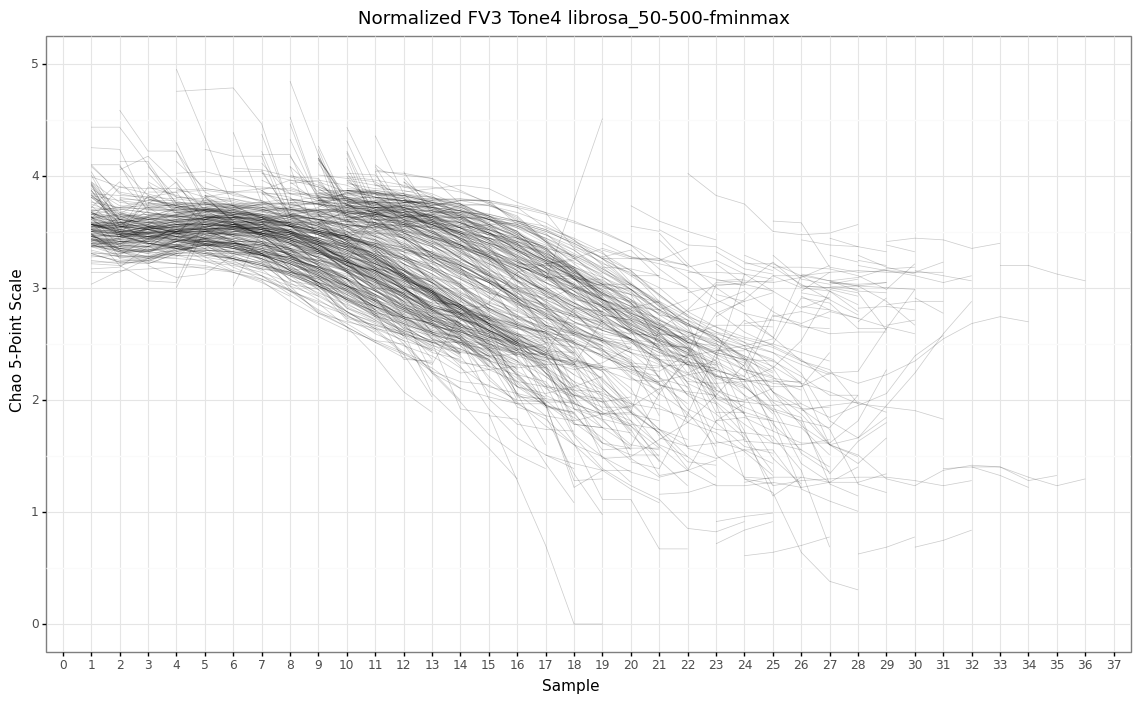

/tmp/ipykernel_149/4125362351.py:103: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/opt/conda/lib/python3.9/site-packages/plotnine/scales/scales.py:29: PlotnineWarning: Scale for 'y' is already present.
Adding another scale for 'y',
which will replace the existing scale.



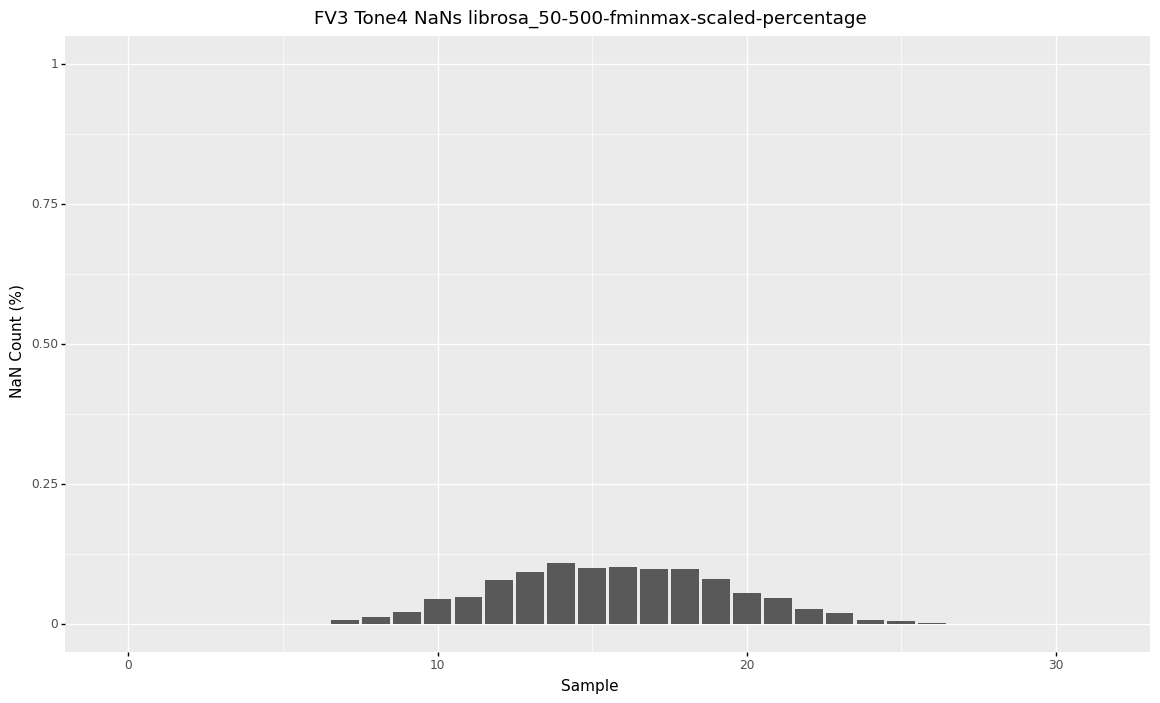

/opt/conda/lib/python3.9/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 72 rows containing missing values.


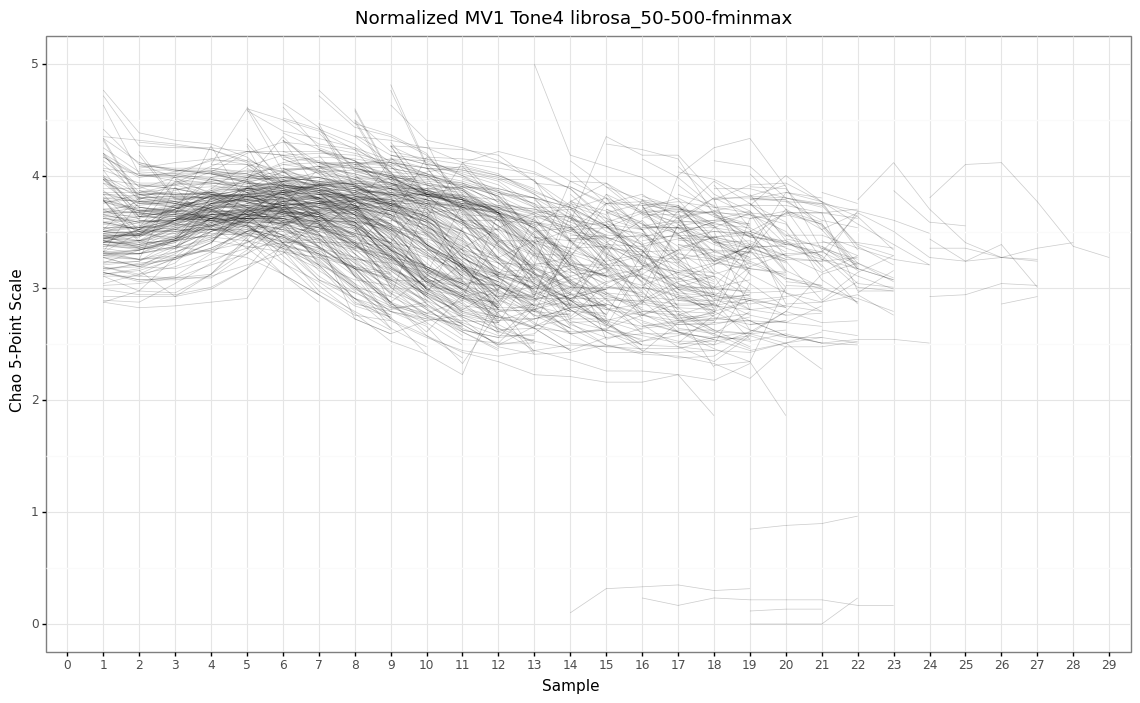

/tmp/ipykernel_149/4125362351.py:103: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/opt/conda/lib/python3.9/site-packages/plotnine/scales/scales.py:29: PlotnineWarning: Scale for 'y' is already present.
Adding another scale for 'y',
which will replace the existing scale.



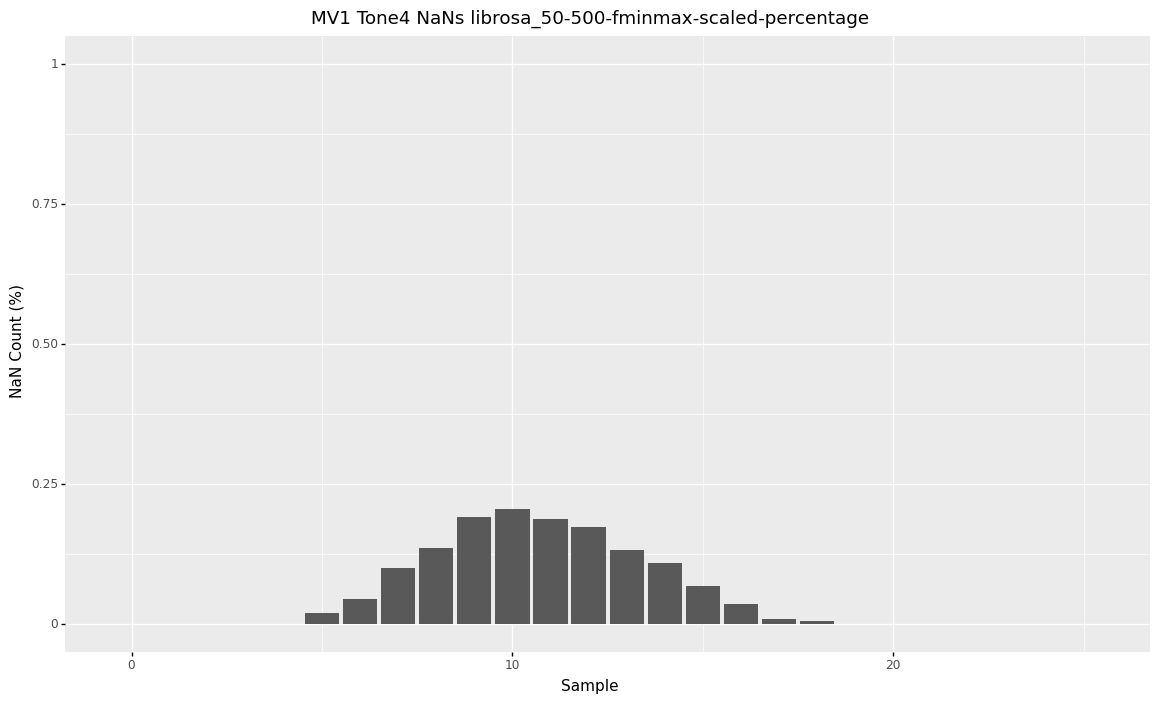

/opt/conda/lib/python3.9/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 28 rows containing missing values.


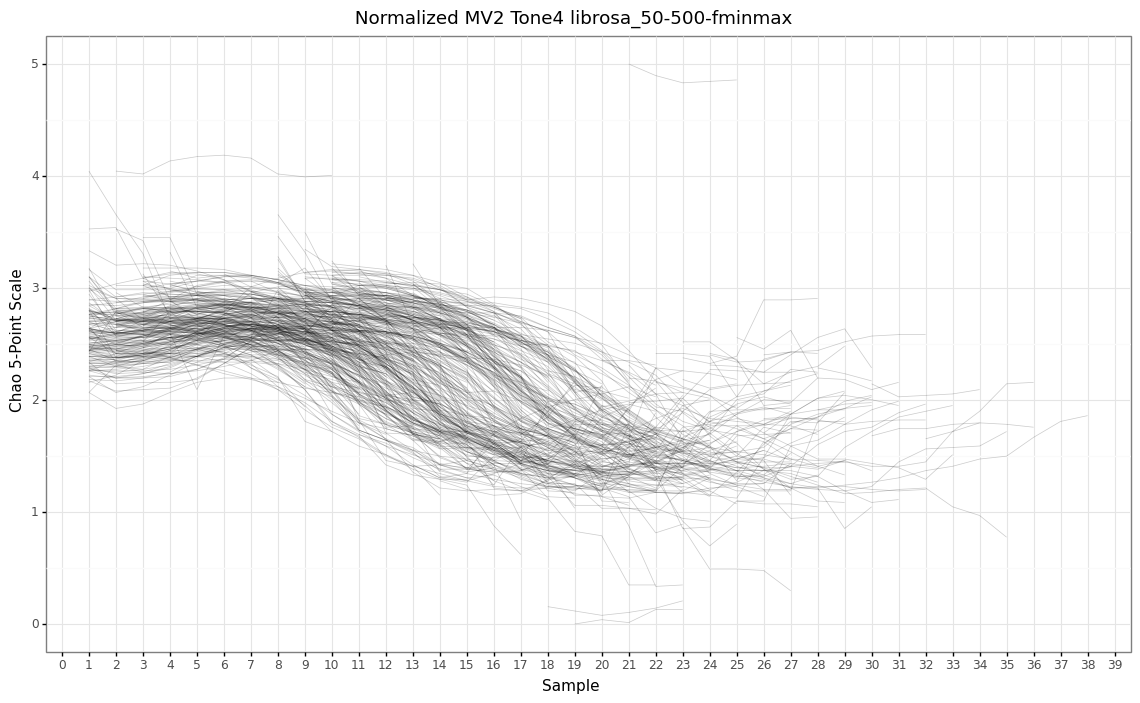

/tmp/ipykernel_149/4125362351.py:103: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/opt/conda/lib/python3.9/site-packages/plotnine/scales/scales.py:29: PlotnineWarning: Scale for 'y' is already present.
Adding another scale for 'y',
which will replace the existing scale.



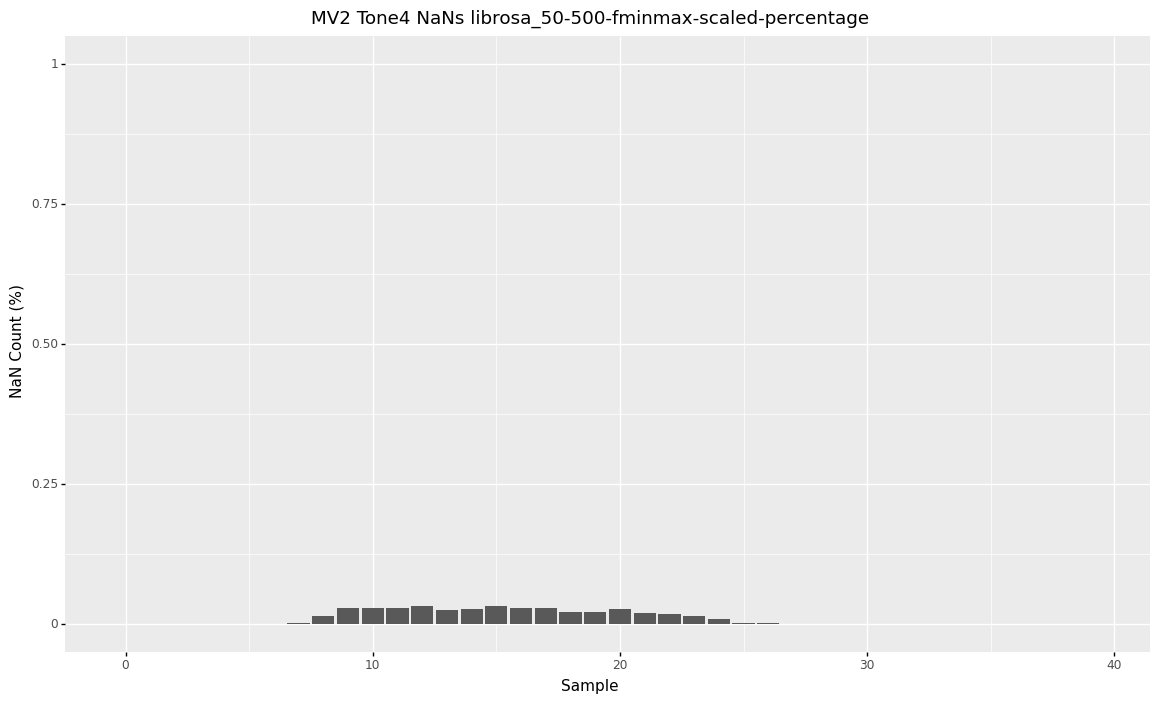

/opt/conda/lib/python3.9/site-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 173 rows containing missing values.


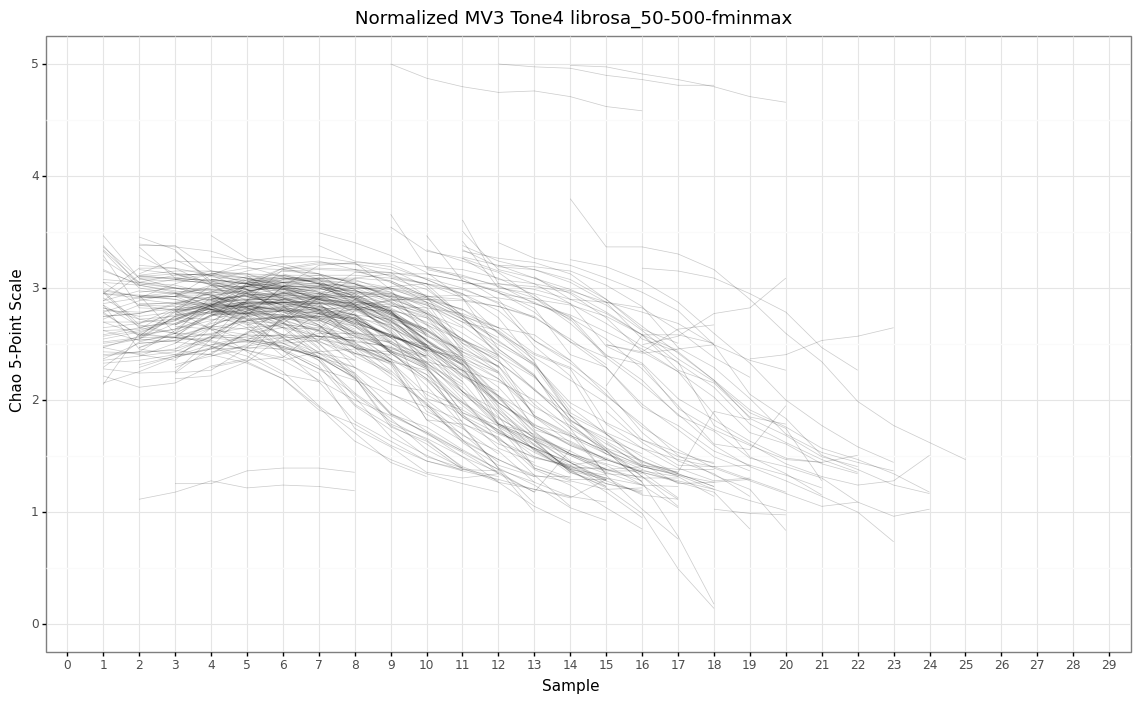

/tmp/ipykernel_149/4125362351.py:103: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/opt/conda/lib/python3.9/site-packages/plotnine/scales/scales.py:29: PlotnineWarning: Scale for 'y' is already present.
Adding another scale for 'y',
which will replace the existing scale.



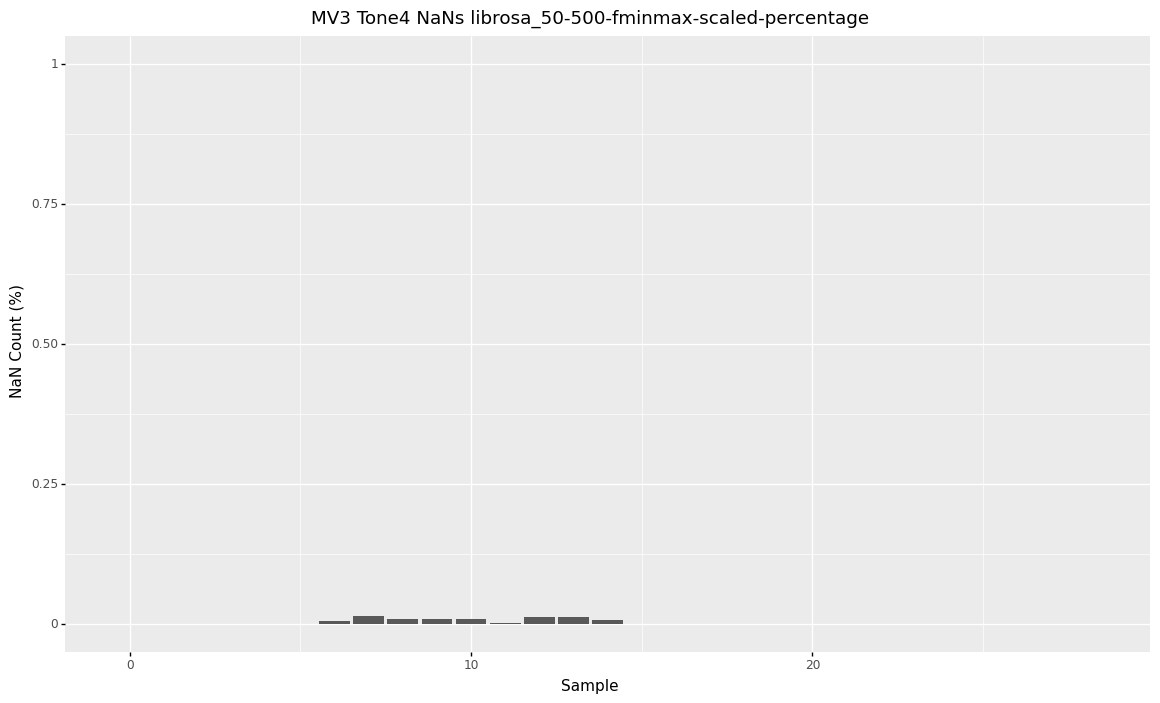

In [44]:
tone4_combos = [(x, y) for x in SPEAKERS for y in [4]]

for item in tone4_combos:
    plot_normalized_pitch(pitch_data_librosa_50_500, item[0], item[1], 'librosa_50-500-fminmax', show=True, save=False)
    plot_nans(pitch_data_librosa_50_500, item[0], item[1], 'librosa_50-500-fminmax-scaled-percentage', show=True, save=False)

